In [1]:
import rebound
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import h5py
from multiprocess import Pool, current_process

# These are random Initial conditions (I think from Chatterjee+2008)

In [204]:
def setup_planet_semi_major_axes(sim, Nplanets):
    a_inner = 3.0  # AU
    a = [a_inner]
    
    for i in range(1, Nplanets):
        ratio = np.random.uniform(1.2, 1.4)
        period_inner = 2 * np.pi * np.sqrt(a[-1]**3 / sim.G / sim.particles[0].m)
        period_outer = period_inner * ratio
        a_outer = (period_outer / (2 * np.pi))**2 * sim.G * sim.particles[0].m
        a.append(a_outer**(1/3))
    
    return a

In [205]:
def initial_conditions(seed, Nplanets=3):
    np.random.seed(seed)
    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')

    sim.add(m=1., hash='star')

    planet_semi_major_axes = setup_planet_semi_major_axes(sim, Nplanets)

    for i in range(Nplanets):
        sim.add(m=1e-3, a=planet_semi_major_axes[i], e=0.01) 

    sim.add(m=0.001, a=3., e=0.01, primary=sim.particles[0], hash='planet 1')  
    sim.add(m=0.001, a=4.6, e=0.01, primary=sim.particles[0], hash='planet 2') 
    sim.add(m=0.001, a=3.5, e=0.01, primary=sim.particles[0], hash='planet 3') 

    for i in range(1, 4):
        sim.particles[i].inc = np.random.rayleigh(0.01)
        sim.particles[i].Omega = np.random.uniform(0, 2*np.pi)
        sim.particles[i].omega = np.random.uniform(0, 2*np.pi)
        sim.particles[i].f = np.random.uniform(0, 2*np.pi)

    N_moons = 10
    for i in range(N_moons):
        a_moon = 0.001 * (2 + 2*i)  
        sim.add(m=0., a=a_moon, e=0., primary=sim.particles[1])
    sim.move_to_com()

    return sim

In [206]:
sim_id = 6
sim = initial_conditions(sim_id)
sim.status()

---------------------------------
REBOUND version:     	3.25.1
REBOUND built on:    	Jul  4 2023 15:37:44
Number of particles: 	17
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x136e7b1d0, m=1.0 x=-0.010345963122153365 y=0.004243591654990982 z=3.8207001765459376e-05 vx=-0.0038942113455863623 vy=-0.009021609570567494 vz=-4.473088644646391e-05>
<rebound.particle.Particle object at 0x135f98440, m=0.001 x=-0.11677797309395763 y=-3.0181181398504586 z=-0.0536260529953091 vx=3.5940659129334533 vy=-0.11495580388607664 vz=-0.019237578580943777>
<rebound.particle.Particle object at 0x136e7b1d0, m=0.001 x=-2.702274444604396 y=2.6348974772667866 z=-0.012103442552616623 vx=-2.2346953984707345 vy=-2.335332333583019 vz=0.03828125263125201>
<rebound.particle.Particle object at 0x135f98440, m=0.001 x=2.2070534292181736 y=-3.8731017673722796 z=0.02740787277717 vx=2.5465234651

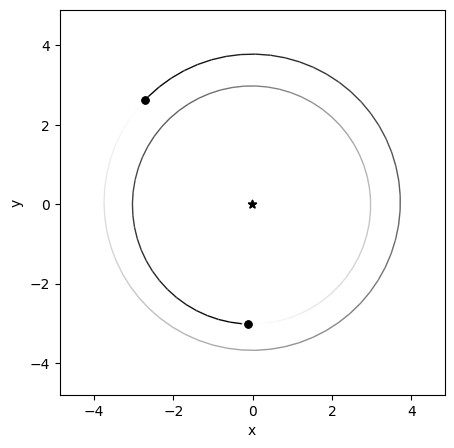

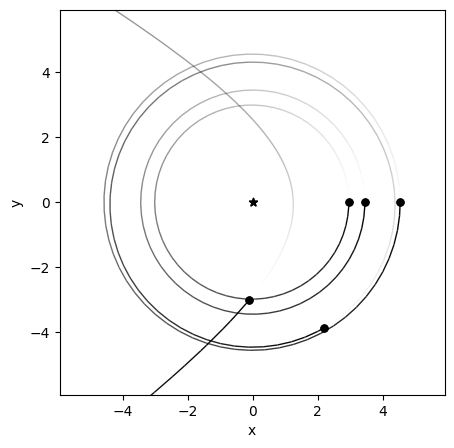

In [207]:
%matplotlib inline
op = rebound.OrbitPlot(sim, particles=[1,2])
op = rebound.OrbitPlot(sim, particles=[3,4,5, 6, 7])

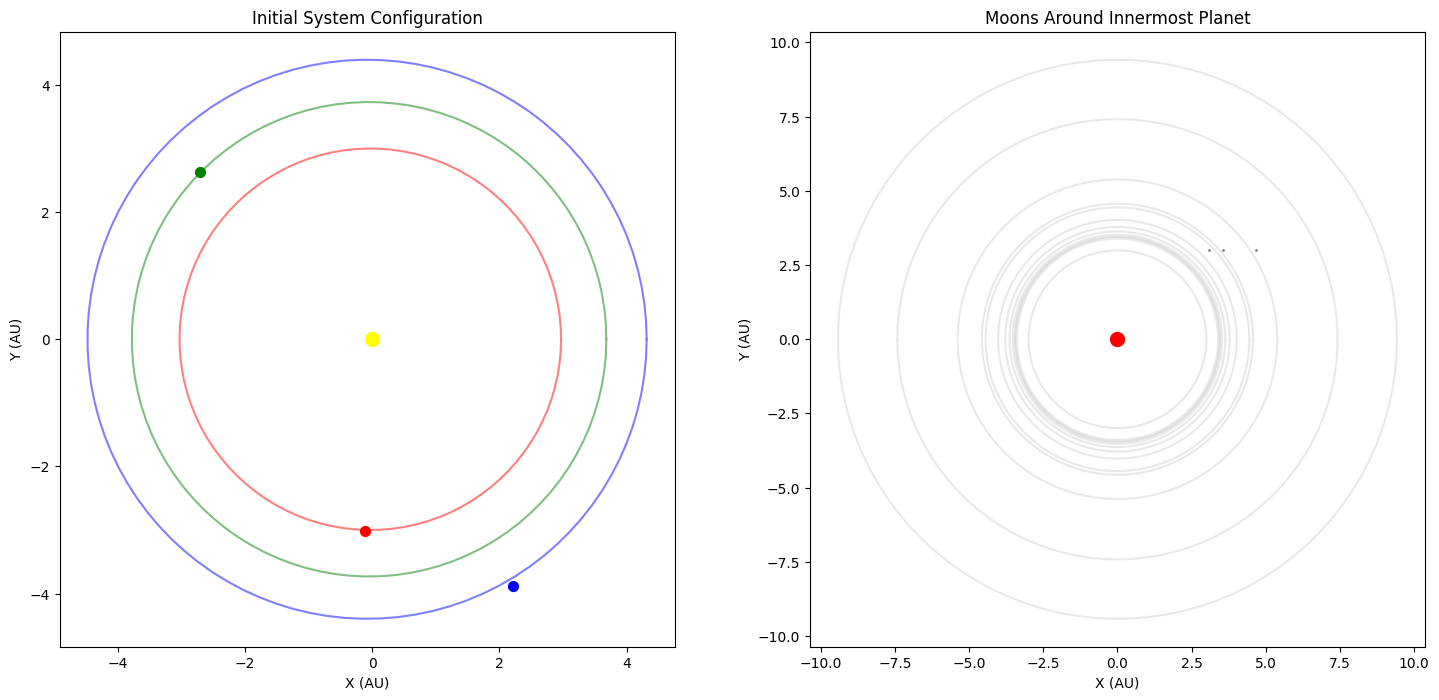

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Plot the entire system
ax1.set_aspect('equal')
ax1.set_title('Initial System Configuration')
ax1.set_xlabel('X (AU)')
ax1.set_ylabel('Y (AU)')

colors = ['yellow', 'red', 'green', 'blue']
sizes = [100, 50, 50, 50]
for i, p in enumerate(sim.particles[:4]):  # Star and planets
    ax1.scatter(p.x, p.y, color=colors[i], s=sizes[i], zorder=3)
    if i > 0:  
        orbit = p.orbit
        t = np.linspace(0, 2*np.pi, 100)
        x = orbit.a * (np.cos(t) - orbit.e)
        y = orbit.a * np.sqrt(1 - orbit.e**2) * np.sin(t)
        ax1.plot(x, y, color=colors[i], alpha=0.5)

ax2.set_aspect('equal')
ax2.set_title('Moons Around Innermost Planet')
ax2.set_xlabel('X (AU)')
ax2.set_ylabel('Y (AU)')

p1 = sim.particles[1]  # Innermost planet
ax2.scatter(0, 0, color='red', s=100, zorder=3)  # Planet at center

for p in sim.particles[4:]:  # Moons
    rel_x = p.x - p1.x
    rel_y = p.y - p1.y
    ax2.scatter(rel_x, rel_y, color='gray', s=1, zorder=2)
    orbit = p.orbit
    t = np.linspace(0, 2*np.pi, 100)
    x = orbit.a * np.cos(t)
    y = orbit.a * np.sin(t)
    ax2.plot(x, y, color='lightgray', alpha=0.5, zorder=1)

plt.tight_layout()
plt.show()

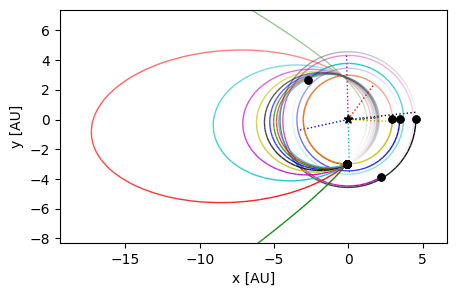

In [209]:
sim.move_to_com()
op = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True)

In [212]:
Noutputs = 1000
tmax = 1e6

In [213]:
sim.exit_max_distance = 100.
times = np.linspace(0., tmax, Noutputs)
sim.integrator = "whfast"
os = sim.calculate_orbits()
sim.dt = 0.005 * os[0].P

### The general idea of the code below is to eject planets, and then to process the planets that are still in the system. I found it difficult to do it with hashing in Rebound, so I did that by following the indices. This code ejects moons and planets separately -- that's probably not the best approach. The approach that Ian used was eject planets first, and then go back to them and add Galilean moons around the escaping planets.

In [ ]:
Nplanets = 3  
Nmoons = 10  
Ntotal = 1 + Nplanets + Nmoons  # Total number of bodies including the star

ecc = np.zeros((Ntotal, Noutputs))
a = np.zeros((Ntotal, Noutputs))
inc = np.zeros((Ntotal, Noutputs))
omega = np.zeros((Ntotal, Noutputs))

indices = np.arange(Ntotal).astype('int')
planet_indices = np.arange(1, Nplanets+1).astype('int')  # Planets start at index 1
moon_indices = np.arange(Nplanets+1, Ntotal).astype('int')  # Moons start after planets

for i, time in enumerate(times):
    try:
        sim.integrate(time, exact_finish_time=0)
        os = sim.calculate_orbits()

        # Process planets
        for j, planet_idx in enumerate(planet_indices):
            if planet_idx > 0:  # Check if planet is still in the simulation
                ecc[j][i] = os[planet_idx - 1].e  # -1 because os doesn't include star
                a[j][i] = os[planet_idx - 1].a
                inc[j][i] = os[planet_idx - 1].inc
                omega[j][i] = os[planet_idx - 1].omega
            else:
                ecc[j][i] = np.nan
                a[j][i] = np.nan
                inc[j][i] = np.nan
                omega[j][i] = np.nan

        # Process moons of the first planet
        if planet_indices[0] > 0:  # Only process moons if the first planet is still in the simulation
            for k, moon_idx in enumerate(moon_indices):
                idx = Nplanets + k
                if moon_idx > 0:  # Check if moon is still in the simulation
                    ecc[idx][i] = os[moon_idx-1].e
                    a[idx][i] = os[moon_idx-1].a
                    inc[idx][i] = os[moon_idx-1].inc
                    omega[idx][i] = os[moon_idx-1].omega
                else:
                    ecc[idx][i] = np.nan
                    a[idx][i] = np.nan
                    inc[idx][i] = np.nan
                    omega[idx][i] = np.nan
        else:
            # If the first planet is ejected, set all moon parameters to NaN
            for k in range(Nmoons):
                idx = Nplanets + k
                ecc[idx][i] = np.nan
                a[idx][i] = np.nan
                inc[idx][i] = np.nan
                omega[idx][i] = np.nan

    except rebound.Escape as error:
        print(error)
        to_remove = []
        for k, body_idx in enumerate(indices[1:], start=1):  # Start from 1 to skip the star
            # print(sim.particles[int(body_idx)])
            if body_idx < 0: continue
            p = sim.particles[int(body_idx)]
            d2 = p.x * p.x + p.y * p.y + p.z * p.z
            if d2 > sim.exit_max_distance**2:
                to_remove.append((k, body_idx))
        
        print(f"indices before: {indices}")
        
        for k, particle_index in to_remove[::-1]:
            if k <= Nplanets:
                print(f"Planet {k-1} was ejected.")
                sim.remove(index=particle_index)
                indices[k] = -1
                planet_indices[k-1] = -1
                if k == 1:  # If it's the first planet, remove all moons
                    for moon_k in range(Nmoons):
                        moon_idx = Nplanets + 1 + moon_k
                        if indices[moon_idx] > 0:
                            sim.remove(index=indices[moon_idx])
                            indices[moon_idx] = -1
                            moon_indices[moon_k] = -1
            else:
                print(f"Moon {k - Nplanets - 1} of Planet 0 was ejected.")
                sim.remove(index=int(particle_index))
                indices[k] = -1
                moon_indices[k - Nplanets - 1] = -1
            
            # Update indices
            indices[indices > indices[k]] -= 1
            planet_indices[planet_indices > indices[k]] -= 1
            moon_indices[moon_indices > indices[k]] -= 1
        
        print(f"indices after: {indices}")
        print(f"planet_indices after: {planet_indices}")
        print(f"moon_indices after: {moon_indices}")
        print(f"Number of particles is {sim.N}\n")
        sim.move_to_com()

# Analysis of results
for j in range(Ntotal-1):  # -1 to skip the star
    if j < Nplanets:
        body_type = "Planet"
        body_num = j
    else:
        body_type = "Moon"
        body_num = j - Nplanets
    
    last_valid_index = np.where(~np.isnan(a[j]))[0][-1] if np.any(~np.isnan(a[j])) else -1
    
    if last_valid_index == len(times) - 1:
        print(f"{body_type} {body_num} remained in the system throughout the simulation.")
    else:
        print(f"{body_type} {body_num} was ejected at time {times[last_valid_index]}.")
        if body_type == "Moon":
            planet_last_valid_index = np.where(~np.isnan(a[0]))[0][-1]
            if last_valid_index == planet_last_valid_index:
                print(f"  This moon was ejected along with its planet.")
            elif last_valid_index < planet_last_valid_index:
                print(f"  This moon was ejected before its planet.")
            else:
                print(f"  This moon was ejected after its planet.")

A particle escaped (r>exit_max_distance).
indices before: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Moon 6 of Planet 0 was ejected.
indices after: [-1  0  1  2  3  4  5  6  7  8 -1 10 11 12]
planet_indices after: [0 1 2]
moon_indices after: [ 3  4  5  6  7  8 -1 10 11 12]
Number of particles is 16

A particle escaped (r>exit_max_distance).
indices before: [-1  0  1  2  3  4  5  6  7  8 -1 10 11 12]
Moon 7 of Planet 0 was ejected.
indices after: [-1 -1  0  1  2  3  4  5  6  7 -1 -1 10 11]
planet_indices after: [-1  0  1]
moon_indices after: [ 2  3  4  5  6  7 -1 -1 10 11]
Number of particles is 15

A particle escaped (r>exit_max_distance).
indices before: [-1 -1  0  1  2  3  4  5  6  7 -1 -1 10 11]
Moon 1 of Planet 0 was ejected.
indices after: [-1 -1 -1  0  1 -1  3  4  5  6 -1 -1  9 10]
planet_indices after: [-1 -1  0]
moon_indices after: [ 1 -1  3  4  5  6 -1 -1  9 10]
Number of particles is 14

A particle escaped (r>exit_max_distance).
indices before: [-1 -1 -1  0  1 -1  3  4  5  6

In [172]:
body_idx.dtype

dtype('int64')

Text(0, 0.5, 'Eccentricity')

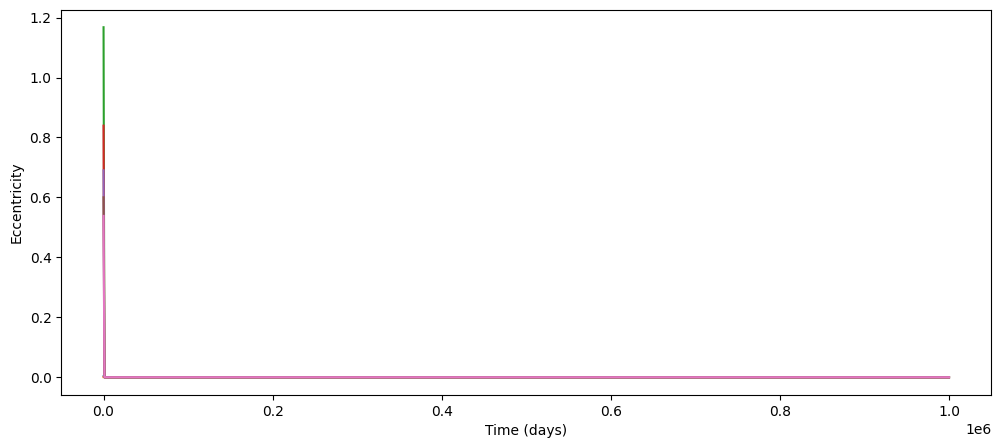

In [215]:
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for i in range(4,11):
    plt.plot(times,ecc[i])
ax.set_xlabel("Time (days)")
ax.set_ylabel("Eccentricity")

In [107]:
ecc

array([[0.01      , 0.00999668, 0.00999337, ..., 0.21472148, 0.21475662,
        0.21478927],
       [0.00795801, 0.00795413, 0.00795026, ..., 0.09710008, 0.09685594,
        0.09661783],
       [0.00984211, 0.00984164, 0.00984121, ..., 0.17116593, 0.17183312,
        0.17249819],
       ...,
       [0.56982452, 1.04219758, 0.85500808, ..., 0.31961453, 0.8536447 ,
        0.79648911],
       [0.53413732, 0.93298487, 0.93374998, ..., 0.69747355, 0.43107508,
        0.26170736],
       [0.50422006, 0.83869535, 0.93277821, ..., 0.68983481, 0.68080973,
        0.48819645]])

# Below is the code with the initial conditions taken from Ian's paper

In [266]:
#Uniform Distribution with low and high adjustable.
def U(l, h):
    return np.random.uniform(low = l, high = h)

#Rayleigh Distribution. Uses the Uniform Distribution.
def Rayleigh (l):
    X = l*np.sqrt(-2*np.log(1-U(0, 1) ))
    return X
    
R = 2*np.pi                     #Radian measures
mjup = 1898.19/1988500          #Mass of Jupiter, in solar masses

In [267]:
def initial_conditions(seed):
    np.random.seed(seed)
    sim = rebound.Simulation()
    sim.units = ('days', 'AU', 'Msun')
    sim.exit_max_distance = 100.0

    sim.add(m=1.0)
    sim.add(m=mjup, a=3.0, e=Rayleigh(0.01), inc=Rayleigh(0.01), omega=U(0,R), Omega=U(0,R), M=U(0,R))
    sim.add(m=mjup, P=sim.particles[1].P*U(1.2,1.4), e=Rayleigh(0.01), inc=Rayleigh(0.01), omega=U(0,R), Omega=U(0,R), M=U(0,R))
    sim.add(m=mjup, P=sim.particles[2].P*U(1.2,1.4), e=Rayleigh(0.01), inc=Rayleigh(0.01), omega=U(0,R), Omega=U(0,R), M=U(0,R))
    sim.move_to_com()

    return sim

In [272]:
def find_unique_log_filename(base_filename):
    copy_number = 0
    while True:
        log_filename = f"{base_filename}{'(' + str(copy_number) + ') ' if copy_number > 0 else ''}.txt"
        if not os.path.exists(log_filename):
            return log_filename
        copy_number += 1

In [273]:
import contextlib
import os
import sys

import h5py
import matplotlib.pyplot as plt
import multiprocess
from multiprocess import current_process
import numpy as np
import pandas as pd
import rebound

# Eject some planets below (no moons)

In [274]:
def simulation(sim_id):
    ecc = np.zeros((Nplanets, Noutputs))
    a = np.zeros((Nplanets, Noutputs))
    inc = np.zeros((Nplanets, Noutputs))
    omega = np.zeros((Nplanets, Noutputs))

    # process_id = current_process()._identity[0]
    process_id = 6

    # Find a unique log file name for each process
    base_log_filename = f"simulation_log_sim{sim_id}_p{process_id}"
    log_filename = find_unique_log_filename(base_log_filename)

    # Generate unique filenames for each simulation result
    result_filename = f"simulation_data_sim{sim_id}_p{process_id}.h5"
    ecc_plot_filename = f"eccentricity_sim{sim_id}_p{process_id}.png"
    semimaj_plot_filename = f"semimaj_sim{sim_id}_p{process_id}.png"

    # with open(log_filename, 'w') as log_file:
    #     # Redirect standard output to the log file
    #     with contextlib.redirect_stdout(log_file):
    seed = int(sim_id * nproc + process_id)
    sim = initial_conditions(sim_id)
    sim.status()
    E0 = sim.energy()
    L0 = sim.calculate_angular_momentum()

    print(f"In the simulation {sim_id}:")

    indices = np.linspace(0, Nplanets-1, Nplanets).astype('int')

    os = sim.calculate_orbits()
    sim.exit_max_distance = 100.
    times = np.linspace(0., tmax, Noutputs)
    sim.integrator = "ias15"
    sim.dt = 0.005 * os[0].P
    sim.automateSimulationArchive(f"sim_archive_sim{sim_id}_p{process_id}.bin",interval=1e3,deletefile=True)

    for i, time in enumerate(times):
        try:
            sim.integrate(time, exact_finish_time=0)
            os = sim.calculate_orbits()

            for j, planet_idx in enumerate(indices):
                if planet_idx > -1:  # Check if planet is still in the simulation
                    ecc[j][i] = os[planet_idx].e
                    a[j][i] = os[planet_idx].a
                    inc[j][i] = os[planet_idx].inc
                    omega[j][i] = os[planet_idx].omega
                else:
                    ecc[j][i] = np.nan  # Set eccentricity to NaN if the planet is ejected
                    a[j][i] = np.nan
                    inc[j][i] = np.nan
                    omega[j][i] = np.nan

        except rebound.Escape as error:
            print(error)
            # os = sim.calculate_orbits()
            to_remove = []
            for k, planet_idx in enumerate(indices):
                if planet_idx < 0: continue
                particle_index = int(planet_idx + 1)
                p = sim.particles[particle_index]
                d2 = p.x * p.x + p.y * p.y + p.z * p.z
                if d2 > sim.exit_max_distance**2:
                    to_remove.append((k, particle_index))
            print(f"indices before: {indices}")

            for k, particle_index in to_remove[::-1]:
                print(f"Planet {k} was ejected.\n")
                print(f"the time is {sim.t}.\n")
                sim.remove(index=particle_index)
                indices[k] = -1
                indices[k+1:] -= 1
            print(f"indices after: {indices}")
            print(f"Number of particles is {sim.N}\n")
            sim.move_to_com()

    Ef = sim.energy()
    Lf = sim.calculate_angular_momentum()
            
    # Save the data to an HDF5 file
    with h5py.File(result_filename, "w") as hdf5_file:
        hdf5_file.create_dataset("eccentricity", data=ecc)
        hdf5_file.create_dataset("semi_major_axis", data=a)
        hdf5_file.create_dataset("inclination", data=inc)
        hdf5_file.create_dataset("arg_of_per", data=omega)

    with h5py.File(result_filename, "r") as hdf5_file:
    # Read the eccentricity and semi-major axis data
        ecc_data = hdf5_file["eccentricity"][:]
        a_data = hdf5_file["semi_major_axis"][:]

    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(111)
    plt.plot(times, ecc_data[0, :], label='Planet 1')
    plt.plot(times, ecc_data[1, :], label='Planet 2')
    plt.plot(times, ecc_data[2, :], label='Planet 3')
    ax.set_xlabel("Time (days)")
    ax.set_ylabel(f"Eccentricity")
    plt.legend()
    # plt.savefig(ecc_plot_filename)
    plt.show()

    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(111)
    plt.plot(times, a_data[0, :], label='Planet 1')
    plt.plot(times, a_data[1, :], label='Planet 2')
    plt.plot(times, a_data[2, :], label='Planet 3')
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Semi-major axis")
    plt.legend()
    plt.show()
    # plt.savefig(semimaj_plot_filename)

    return sim_id, E0, Ef, L0, Lf

---------------------------------
REBOUND version:     	3.25.1
REBOUND built on:    	Jul  4 2023 15:37:44
Number of particles: 	4
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x1374a0710, m=1.0 x=0.0039843538754285885 y=-0.002885832519795894 z=3.302088310624486e-05 vx=5.767550308406688e-06 vy=4.835905612573921e-06 vz=8.524801204814676e-09>
<rebound.particle.Particle object at 0x1374a0e60, m=0.000954583857178778 x=2.9183883451101225 y=-0.4666512147611401 z=-0.01077132127271372 vx=0.0017272415014477776 vy=0.009956409405337012 vz=8.234658992114416e-05>
<rebound.particle.Particle object at 0x1374a0710, m=0.000954583857178778 x=-2.9127000172838793 y=2.18777358853186 z=-0.03753811643487011 vx=-0.005404349748288057 vy=-0.0071274331944484225 vz=1.4271575970456451e-05>
<rebound.particle.Particle object at 0x1374a0e60, m=0.000954583857178778 x=-4.179605417943537 y=1.3

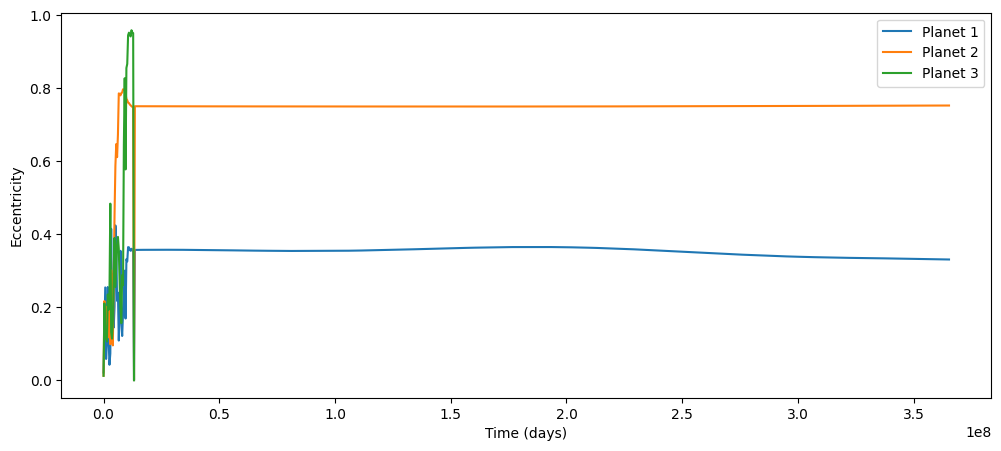

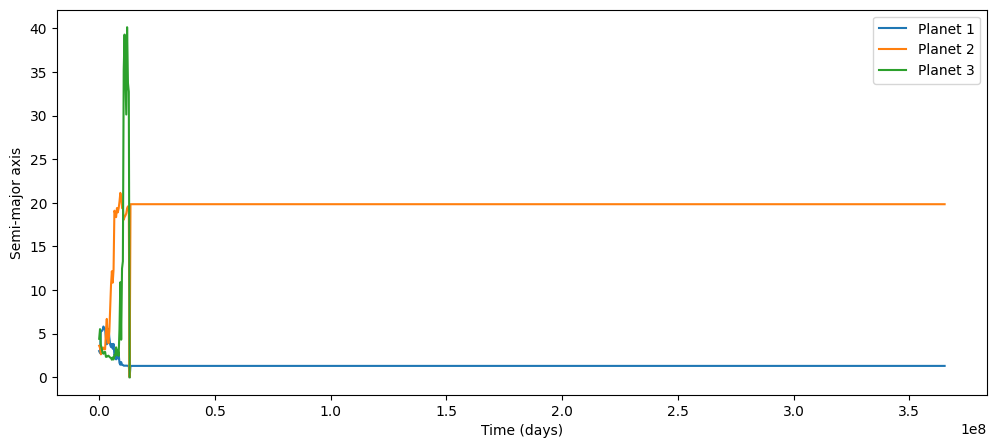

(6,
 -1.1848060505529239e-07,
 -1.159783561799246e-07,
 <rebound.simulation.Vec3d object at 0x13737e950, [-1.8789058325520165e-07, -4.6575410576558365e-07, 9.408449213455701e-05]>,
 <rebound.simulation.Vec3d object at 0x136be9750, [-4.881569094479992e-06, -2.182737465214534e-06, 6.534215868150682e-05]>)

In [ ]:
nproc=1 # number of processors
tmax = 1e6*365.25
simulation(6)

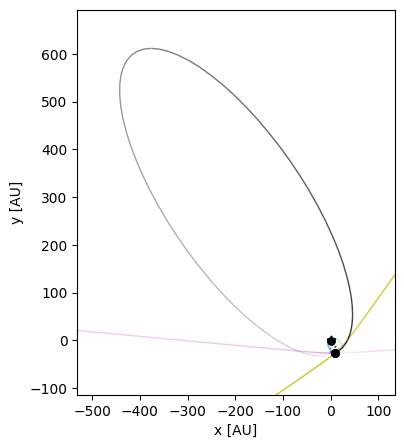

In [277]:
op = rebound.OrbitPlot(sim, unitlabel="[AU]", color=True, periastron=True)

In [279]:
#Important physical constants from the solar system
mJ = 1898.19/1988500        #Jupiter mass
m_moon = 0.07346/1988500    #Moon mass
au = 1.5e8                  #Astronomical Unit
rJ = 70000/au               #Jupiter radius (AU)

In [280]:
sa = rebound.SimulationArchive("sim_archive_sim6_p6.bin")

In [311]:
sa[10000]

<rebound.simulation.Simulation object at 0x1377af0b0, N=4, t=10000001.437551938>

In [298]:
265250003 / 365

726712.3369863014

In [299]:
13040702.289761966 / 365

35727.95147879991

In [312]:
#Initializes a simulation snapshot up to 10 million days back in time.
sa = rebound.SimulationArchive("sim_archive_sim6_p6.bin")
sim = sa[10000]
tf = sim.t + (365.25*100000)    #Final time, set at 100,000 years after the current time

In [320]:
#Add 3 moons in the Laplace resonance.
P = sim.particles[2]
N_moons = 10
sim.add(m=m_moon, primary=P, a=421769/au, e=0.0041, inc=0.036*np.pi/180, l=np.pi/180, hash="Moon 1")
sim.add(m=m_moon, primary=P, a=671079/au, e=0.0101, inc=0.464*np.pi/180, pomega=np.pi, hash="Moon 2")
sim.add(m=m_moon, primary=P, a=1070042/au, e=0.0006, inc=0.186*np.pi/180, l=np.pi, hash="Moon 3")
sim.move_to_com()

In [322]:
sim.exit_max_distance = 100.
times = np.linspace(sim.t, tf, Noutputs)
sim.integrator = "ias15"
os = sim.calculate_orbits()
sim.dt = 0.005 * os[0].P
sim.ri_ias15.min_dt = 0.01

# here is the attempt to eject moons around the escaping planet :)

In [ ]:
Nplanets = 3  
Nmoons = 3  
Ntotal = 1 + Nplanets + Nmoons  # Total number of bodies including the star

ecc = np.zeros((Ntotal, Noutputs))
a = np.zeros((Ntotal, Noutputs))
inc = np.zeros((Ntotal, Noutputs))
omega = np.zeros((Ntotal, Noutputs))

indices = np.arange(Ntotal).astype('int')
planet_indices = np.arange(1, Nplanets+1).astype('int')  # Planets start at index 1
moon_indices = np.arange(Nplanets+1, Ntotal).astype('int')  # Moons start after planets

for i, time in enumerate(times):
    try:
        sim.integrate(time, exact_finish_time=0)
        os = sim.calculate_orbits()

        # Process planets
        for j, planet_idx in enumerate(planet_indices):
            if planet_idx > 0:  # Check if planet is still in the simulation
                ecc[j][i] = os[planet_idx - 1].e  # -1 because os doesn't include star
                a[j][i] = os[planet_idx - 1].a
                inc[j][i] = os[planet_idx - 1].inc
                omega[j][i] = os[planet_idx - 1].omega
            else:
                ecc[j][i] = np.nan
                a[j][i] = np.nan
                inc[j][i] = np.nan
                omega[j][i] = np.nan

        # Process moons of the first planet
        if planet_indices[2] > 0:  # Only process moons if the first planet is still in the simulation
            for k, moon_idx in enumerate(moon_indices):
                idx = Nplanets + k
                if moon_idx > 0:  # Check if moon is still in the simulation
                    ecc[idx][i] = os[moon_idx-1].e
                    a[idx][i] = os[moon_idx-1].a
                    inc[idx][i] = os[moon_idx-1].inc
                    omega[idx][i] = os[moon_idx-1].omega
                else:
                    ecc[idx][i] = np.nan
                    a[idx][i] = np.nan
                    inc[idx][i] = np.nan
                    omega[idx][i] = np.nan
        else:
            # If the first planet is ejected, set all moon parameters to NaN
            for k in range(Nmoons):
                idx = Nplanets + k
                ecc[idx][i] = np.nan
                a[idx][i] = np.nan
                inc[idx][i] = np.nan
                omega[idx][i] = np.nan

    except rebound.Escape as error:
        print(error)
        to_remove = []
        for k, body_idx in enumerate(indices[1:], start=1):  # Start from 1 to skip the star
            # print(sim.particles[int(body_idx)])
            if body_idx < 0: continue
            p = sim.particles[int(body_idx)]
            d2 = p.x * p.x + p.y * p.y + p.z * p.z
            if d2 > sim.exit_max_distance**2:
                to_remove.append((k, body_idx))
        
        print(f"indices before: {indices}")
        
        for k, particle_index in to_remove[::-1]:
            if k <= Nplanets:
                print(f"Planet {k-1} was ejected.")
                sim.remove(index=particle_index)
                indices[k] = -1
                planet_indices[k-1] = -1
                if k == 1:  # If it's the first planet, remove all moons
                    for moon_k in range(Nmoons):
                        moon_idx = Nplanets + 1 + moon_k
                        if indices[moon_idx] > 0:
                            sim.remove(index=indices[moon_idx])
                            indices[moon_idx] = -1
                            moon_indices[moon_k] = -1
            else:
                print(f"Moon {k - Nplanets - 1} of Planet 0 was ejected.")
                sim.remove(index=int(particle_index))
                indices[k] = -1
                moon_indices[k - Nplanets - 1] = -1
            
            # Update indices
            indices[indices > indices[k]] -= 1
            planet_indices[planet_indices > indices[k]] -= 1
            moon_indices[moon_indices > indices[k]] -= 1
        
        print(f"indices after: {indices}")
        print(f"planet_indices after: {planet_indices}")
        print(f"moon_indices after: {moon_indices}")
        print(f"Number of particles is {sim.N}\n")
        sim.move_to_com()

# Analysis of results
for j in range(Ntotal-1):  # -1 to skip the star
    if j < Nplanets:
        body_type = "Planet"
        body_num = j
    else:
        body_type = "Moon"
        body_num = j - Nplanets
    
    last_valid_index = np.where(~np.isnan(a[j]))[0][-1] if np.any(~np.isnan(a[j])) else -1
    
    if last_valid_index == len(times) - 1:
        print(f"{body_type} {body_num} remained in the system throughout the simulation.")
    else:
        print(f"{body_type} {body_num} was ejected at time {times[last_valid_index]}.")
        if body_type == "Moon":
            planet_last_valid_index = np.where(~np.isnan(a[0]))[0][-1]
            if last_valid_index == planet_last_valid_index:
                print(f"  This moon was ejected along with its planet.")
            elif last_valid_index < planet_last_valid_index:
                print(f"  This moon was ejected before its planet.")
            else:
                print(f"  This moon was ejected after its planet.")

KeyboardInterrupt: 